# **Identifying Key Entities in Recipe Data**

Vineeth B


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [ ]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [ ]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [ ]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [ ]:
# define a function to load json file to a dataframe
def load_json_dataframe(file_path):

    try:
        with open(file_path, 'r') as f:
            data = json.load(f)  # Load JSON data from the file
        df = pd.DataFrame(data)  # Create a DataFrame from the JSON data
        return df
    except FileNotFoundError:
        print(f"Error: File not found at path: {file_path}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in file: {file_path}")
        return None

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [ ]:
# read the json file by giving the file path and create a dataframe
df = load_json_dataframe('ingredient_and_quantity.json')

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [ ]:
# display first five rows of the dataframe - df
print("First five rows:")
display(df.head())

First five rows:


input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [ ]:
# print the dimensions of dataframe - df
print("\nDimensions:")
print(df.shape)


Dimensions:
(285, 2)


In [ ]:
# print the information of the dataframe
print("\nInformation:")
df.info()


Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [ ]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df['input_tokens'] = df['input'].str.split()

# Tokenize POS
df['pos_tokens'] = df['pos'].str.split()

In [ ]:
# display first five rows of the dataframe - df
display(df.head())

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                               

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [ ]:
# create input_length and pos_length columns for the input_tokens and pos_tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

In [ ]:
# check for the equality of input_length and pos_length in the dataframe


unequal_rows = df[df['input_length'] != df['pos_length']]

print("Unequal Rows:")
display(unequal_rows)

print("\nNumber of unequal rows:", len(unequal_rows))

Unequal Rows:


input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               pos                                                                                                                                                                                                                                                                                                                                                                                input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length
17                                                                                                                                                                                                                                                   2 cups curd 1 cup gourd cucumber green cor coriander 1/2 teaspoon cumin powder salt                                                                                                                                                                                                                                                                                                                                                                                                                 quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                         [2, cups, curd, 1, cup, gourd, cucumber, green, cor, coriander, 1/2, teaspoon, cumin, powder, salt]                                                                                                                                                                                                                                                                                                                                                                                                                                                        [quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          14
27                                                                                   1 Baguette sliced 1 1/2 tablespoon Butter 1/2 Garlic minced cup Spinach Leaves Palak Red Bell pepper Capsicum Tomato finely chopped Onion Black powder Italian seasoning teaspoon Fresh cream Cheddar cheese grated Salt Roasted tomato pasta sauce                                                                                                                                                               quantity ingredient ingredient quantity unit ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient in


Number of unequal rows: 5


##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [ ]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it

def unique_labels(df):

    all_labels = []
    for label_list in df['pos_tokens']:
        all_labels.extend(label_list)  # Add all labels to the list
    unique_labels = set(all_labels)  # Convert to set to get unique labels
    print("Unique POS labels in the recipe data:")
    for label in unique_labels:
        print(label)


unique_labels(df)

Unique POS labels in the recipe data:
unit
ingredient
quantity


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>


In [ ]:
indexes_to_clean = unequal_rows.index

print("Indexes to clean:", indexes_to_clean)

Indexes to clean: Index([17, 27, 79, 164, 207], dtype='int64')


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [ ]:
# drop the irrelevant recipe data
df = df.drop(indexes_to_clean)

df = df.reset_index(drop=True)

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [ ]:
# update the input and pos length in input_length and pos_length
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [ ]:
# validate the input length and pos length as input_length and pos_length
unequal_rows = df[df['input_length'] != df['pos_length']]

print("Unequal Rows:")
display(unequal_rows)

print("\nNumber of unequal rows:", len(unequal_rows))

Unequal Rows:


Empty DataFrame
Columns: [input, pos, input_tokens, pos_tokens, input_length, pos_length]
Index: []


Number of unequal rows: 0


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [ ]:
# split the dataset into training and validation sets

X = df[['input', 'input_tokens']]
y = df['pos_tokens']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

train_df = pd.DataFrame({'input': X_train['input'], 'input_tokens': X_train['input_tokens'], 'pos_tokens': y_train})
val_df = pd.DataFrame({'input': X_val['input'], 'input_tokens': X_val['input_tokens'], 'pos_tokens': y_val})


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [ ]:
# print the first five rows of train_df

print("First five rows of train_df:")
display(train_df.head())

First five rows of train_df:


input                                                                                                                                                                                                                                                                                           input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                          pos_tokens
175                                                        250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric                                                                  [250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]                                                                                                                                  [quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
55   200 grams Paneer Homemade Cottage Cheese 2 Potato Aloo Bay leaf tej patta Dry Red Chilli 1 tablespoon Panch Phoran Masala roasted and powdered Tomato big sized teaspoon Turmeric powder Haldi Cumin seeds Jeera Ginger grated Salt 1/2 Sugar Sunflower Oil  [200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]  [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient]
109                                                                                                       500 grams Cabbage Patta Gobi Muttaikose 1 teaspoon Mustard seeds 1-1/2 White Urad Dal Split sprig Curry leaves Green Chilli 1/4 cup Fresh coconut Salt                                                                                                                       [500, grams, Cabbage, Patta, Gobi, Muttaikose, 1, teaspoon, Mustard, seeds, 1-1/2, White, Urad, Dal, Split, sprig, Curry, leaves, Green, Chilli, 1/4, cup, Fresh, coconut, Salt]                                                                                                                                                                                                        [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]
213                                                                                                                                          500 grams Fresh Figs 1/4 cup L

In [ ]:
# print the first five rows of the val_df

print("\nFirst five rows of val_df:")
display(val_df.head())


First five rows of val_df:


input                                                                                                                                                                                                                                                                                                                                                                                                                        input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pos_tokens
33                                                                                                                                                                                                                                                                                       1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi                                                                                                                                                                                                                                                                                                                               [1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]
108  1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 Cloves Laung Cardamom Elaichi Pods/Seeds Cumin Jeera  [1, Carrot, Gajjar, chopped, 7, Potatoes, Aloo, 2, cups, Cauliflower, gobi, cut, to, small, florets, Onion, tablespoon, Ginger, Garlic, Paste, Salt, teaspoons, Sunflower, Oil, 1/2, cup, Fresh, coconut, grated, teaspoon, Whole, Black, Peppercorns, Green, Chillies, Fennel, seeds, Saunf, Poppy, 6, Cashew, nuts, inch, Cinnamon, Stick, Dalchini, Star, anise, 3, Cloves, Laung, Cardamom, Elaichi, Pods/Seeds, Cumin, Jeera]  [quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
240                                                                                                                       

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [ ]:
# extract the training and validation sets by taking input_tokens and pos_tokens

X_train = train_df['input_tokens'].tolist()
X_val = val_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

In [ ]:
# validate the shape of training and validation samples

print("Length of X_train:", len(X_train))
print("Length of X_val:", len(X_val))
print("Length of y_train:", len(y_train))
print("Length of y_val:", len(y_val))

assert len(X_train) == len(y_train), "Training data shapes mismatch!"
assert len(X_val) == len(y_val), "Validation data shapes mismatch!"

print("\nData shapes validated successfully.")

Length of X_train: 196
Length of X_val: 84
Length of y_train: 196
Length of y_val: 84

Data shapes validated successfully.


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [ ]:
# Display the number of unique labels present in y_train
# Flatten y_train to get all labels
all_labels = [label for sublist in y_train for label in sublist]

# Get unique labels
unique_labels = set(all_labels)

# Display the number of unique labels
print("Number of unique labels in y_train:", len(unique_labels))

Number of unique labels in y_train: 3


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [ ]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):

    return [item for sublist in nested_list for item in sublist]

In [ ]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [ ]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens


def extract_and_validate_tokens(dataframe, dataset_name):

    # Flatten input_tokens and pos_tokens
    all_input_tokens = flatten_list(dataframe['input_tokens'].tolist())
    all_pos_tokens = flatten_list(dataframe['pos_tokens'].tolist())

    # Validate lengths
    if len(all_input_tokens) == len(all_pos_tokens):
        print(f"Success: Input and POS token lengths match in {dataset_name} data!")
    else:
        print(f"Error: Input and POS token lengths mismatch in {dataset_name} data!")

    # Display first 10 records
    print(f"First 10 input tokens in {dataset_name} data:")
    print(all_input_tokens[:10])
    print(f"\nFirst 10 POS tokens in {dataset_name} data:")
    print(all_pos_tokens[:10])



In [ ]:
# extract the tokens and its pos tags

# Execute the function for training data
extract_and_validate_tokens(train_df, dataset_name)

Success: Input and POS token lengths match in Training data!
First 10 input tokens in Training data:
['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated']

First 10 POS tokens in Training data:
['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [ ]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays
def categorize_tokens(input_tokens, pos_tokens):

    ingredients = []
    units = []
    quantities = []

    for token, pos_tag in zip(input_tokens, pos_tokens):
        if pos_tag == 'ingredient':
            ingredients.append(token)
        elif pos_tag == 'unit':
            units.append(token)
        elif pos_tag == 'quantity':
            quantities.append(token)

    return ingredients, units, quantities




In [ ]:
#  call the function to categorise the labels into respective list

ingredients, units, quantities = categorize_tokens(all_input_tokens_train, all_pos_tokens_train)

print("Ingredients:", ingredients)
print("Units:", units)
print("Quantities:", quantities)

Ingredients: ['Okra', 'Oil', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'Ginger', 'Garlic', 'Finely', 'Cumin', 'seeds', 'asafoetida', 'cottage', 'cheese', 'pinched', 'coriander', 'powder', 'mango', 'red', 'chilli', 'turmeric', 'Paneer', 'Homemade', 'Cottage', 'Cheese', 'Potato', 'Aloo', 'Bay', 'leaf', 'tej', 'patta', 'Dry', 'Red', 'Chilli', 'Panch', 'Phoran', 'Masala', 'roasted', 'and', 'powdered', 'Tomato', 'big', 'sized', 'Turmeric', 'powder', 'Haldi', 'Cumin', 'seeds', 'Jeera', 'Ginger', 'grated', 'Salt', 'Sugar', 'Sunflower', 'Oil', 'Cabbage', 'Patta', 'Gobi', 'Muttaikose', 'Mustard', 'seeds', 'White', 'Urad', 'Dal', 'Split', 'Curry', 'leaves', 'Green', 'Chilli', 'Fresh', 'coconut', 'Salt', 'Fresh', 'Figs', 'Lemon', 'juice', 'zest', 'Red', 'Chilli', 'flakes', 'Honey', 'Brown', 'Sugar', '(Demerara', 'Sugar)', 'Water', 'Tea', 'leaves', 'Milk', 'Saffron', 'strands', 'Rice', 'Green', 'peas', 'Potatoes', 'Aloo', 'Onion', 'Ginger', 'Garlic', 'Paste', 'Chillies', 'Black', 'cardamom

#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [ ]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
def get_top_frequent_items(item_list, top_n=10):

    item_frequencies = Counter(item_list)
    top_items = item_frequencies.most_common(top_n)
    return top_items

In [ ]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients = get_top_frequent_items(ingredients)
print("Top 10 most frequent ingredients:", top_ingredients)


Top 10 most frequent ingredients: [('powder', 129), ('Salt', 102), ('seeds', 89), ('Green', 85), ('chopped', 84), ('Oil', 83), ('Red', 81), ('Chilli', 77), ('Coriander', 71), ('Sunflower', 65)]


In [ ]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(units)
print("\nTop 10 most frequent units:", top_units)


Top 10 most frequent units: [('teaspoon', 162), ('cup', 136), ('tablespoon', 99), ('grams', 63), ('tablespoons', 61), ('inch', 52), ('cups', 50), ('sprig', 41), ('cloves', 39), ('teaspoons', 39)]


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [ ]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
def plot_top_items(top_items, label, dataset_name):

    items, frequencies = zip(*top_items)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=frequencies, y=items)
    plt.title(f'Top 10 Most Frequent {label} in {dataset_name} Data')
    plt.xlabel('Frequency')
    plt.ylabel(label)
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



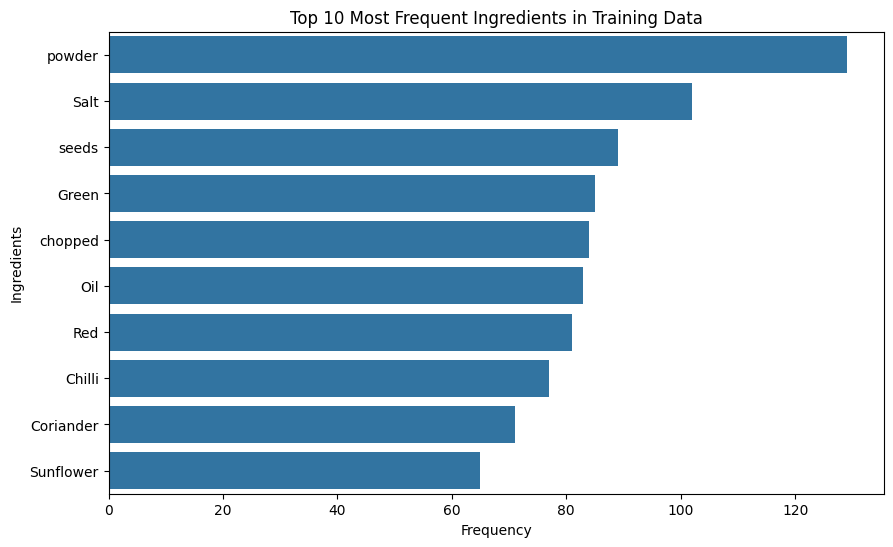

In [ ]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients, 'Ingredients', dataset_name)

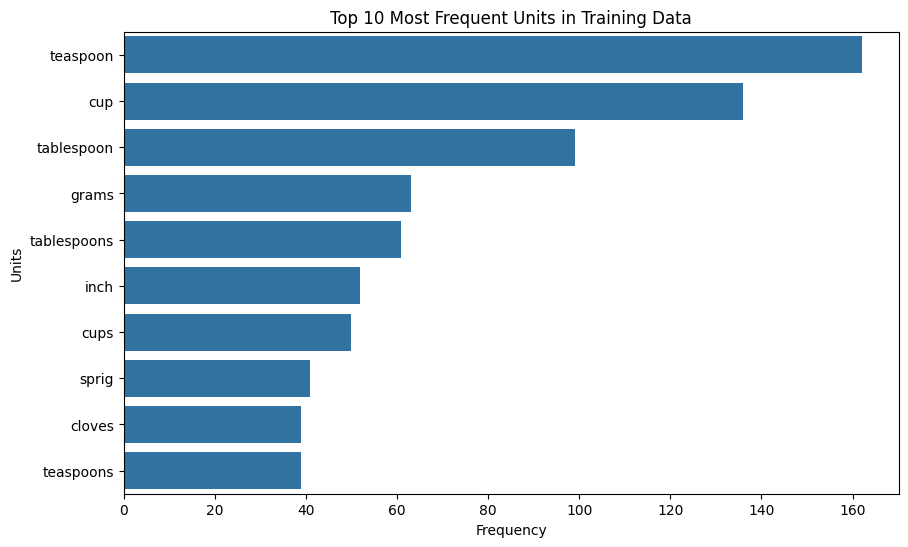

In [ ]:
# plot the top frequent units in training data
plot_top_items(top_units, 'Units', dataset_name)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [ ]:
# initialise the dataset_name
val_dataset_name = 'Validation'

In [ ]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe

all_input_tokens_val = flatten_list(X_val)
all_pos_tokens_val = flatten_list(y_val)

ingredients_val, units_val, quantities_val = categorize_tokens(all_input_tokens_val, all_pos_tokens_val)

top_ingredients_val = get_top_frequent_items(ingredients_val)
top_units_val = get_top_frequent_items(units_val)

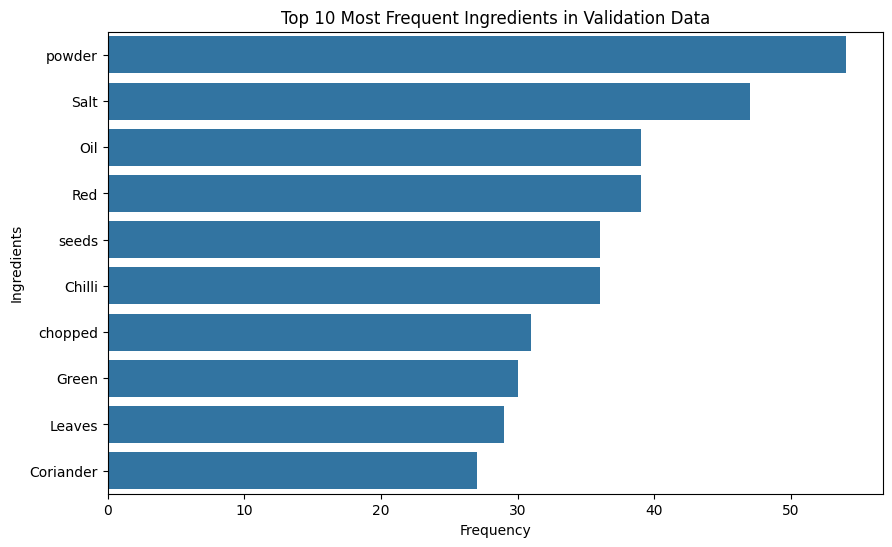

In [ ]:
# plot the top frequent ingredients in validation data
plot_top_items(top_ingredients_val, 'Ingredients', val_dataset_name)

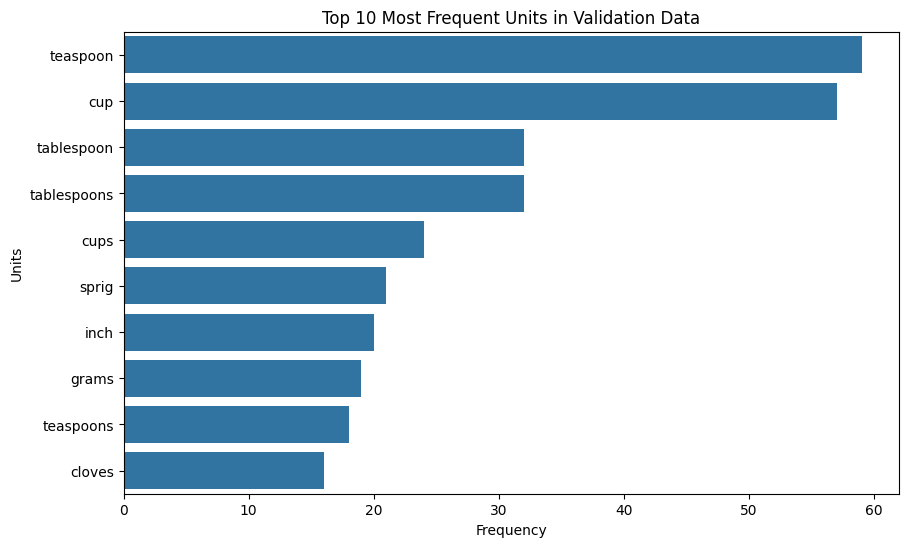

In [ ]:
# plot the top frequent units in training data
plot_top_items(top_units_val, 'Units', val_dataset_name)

Insights:

*   Powder and Salt are top 2 ingredients in both Train and Validation dataset
*   Most of the top 10 ingredients in train are present in top 10 of validation set as well, indicating that validation data adequately represents the overall recipe data.
*   teaspoon and cup are top 2 units in both Train and Validation dataset
*   Most of the top 10 units in train are present in top 10 of validation set as well, indicating that validation data adequately represents the overall recipe data.





## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [ ]:
# define unit and quantity keywords along with quantity pattern
unit_keywords = {
    'cup', 'cups', 'tbsp', 'tsp', 'teaspoon', 'tablespoons', 'tablespoon',
    'g', 'kg', 'ml', 'l', 'ounce', 'oz', 'pound', 'lb', 'pinch', 'dash',
    'handful', 'clove', 'cloves', 'drops', 'fistful', 'inch', 'inches',
    'liter', 'scoops', 'small', 'medium', 'large', 'sprig', 'sprigs',
    'stalks', 'wedges'}
quantity_keywords = {'half', 'quarter', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'a','an','dash'}  # Add more as needed

# Define quantity pattern using regex
quantity_pattern = r'^(\d+\s?\d+\/\d+|\d*\.?\d+)$'
# \d+\/\d+: Matches fractions
# \d*\.?\d+: Matches numbers (including decimals)
# \d+\s? Allow optional space between digits


In [ ]:
# load spaCy model
nlp = spacy.load("en_core_web_sm")

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [ ]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions
def word2features(sent, i):
    """
    Extracts features for a token in a sentence.
    """
    word = sent[i]


    # --- Core Features ---
    features = {
        'bias': 1.0,
        'token': word.lower_,
        'lemma': word.lemma_,
        'pos_tag': word.pos_,
        'tag': word.tag_,
        'dep': word.dep_,
        'shape': word.shape_,
        'is_stop': word.is_stop,
        'is_digit': word.is_digit,
        'has_digit': any(char.isdigit() for char in word.text),
        'has_alpha': any(char.isalpha() for char in word.text),
        'hyphenated': '-' in word.text,
        'slash_present': '/' in word.text,
        'is_title': word.is_title,
        'is_upper': word.is_upper,
        'is_punct': word.is_punct,
    }
    # --- Improved Quantity & Unit Detection ---
    features.update({
        'is_quantity': re.match(quantity_pattern, word.text) is not None or word.lower_ in quantity_keywords,
        'is_unit': word.lower_ in unit_keywords,
        'is_numeric': word.like_num,
        'is_fraction': bool(re.search(r'\d+\/\d+', word.text)),
        'is_decimal': bool(re.search(r'\d+\.\d+', word.text)),
    })

    # --- Contextual Features ---
    if i > 0:
        prev_word = sent[i - 1]
        features.update({
            'prev_token': prev_word.lower_,
            'prev_is_quantity': re.match(quantity_pattern, prev_word.text) is not None or prev_word.lower_ in quantity_keywords,
            'prev_is_digit': prev_word.is_digit,
            'BOS': False,
            'preceding_word': prev_word.text
        })
    else:
        features['BOS'] = True

    if i < len(sent) - 1:
        next_word = sent[i + 1]
        features.update({
            'next_token': next_word.lower_,
            'next_is_unit': next_word.lower_ in unit_keywords,
            'next_is_ingredient': not (re.match(quantity_pattern, next_word.text) is not None or next_word.lower_ in quantity_keywords or next_word.lower_ in unit_keywords),
            'EOS': False,
            'following_word': next_word.text
        })
    else:
        features['EOS'] = True

    # Improvements based on error insights of 1st iteration
    features['is_hyphenated_quantity'] = features['is_quantity'] and features['hyphenated']
    features['prev_is_numeric'] = sent[i - 1].like_num if i > 0 else False  # Check if previous token is numeric
    features['next_is_ingredient_like'] = any(char.isalpha() for char in next_word.text) if i < len(sent) - 1 else False  # Check if next token is likely an ingredient
    features['is_all_caps'] = word.text.isupper()
    features['is_first_cap'] = word.text[0].isupper() if word.text else False
    features['is_single_digit_quantity'] = word.is_digit and len(word.text) == 1
    return features


### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [ ]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features

def sent2features(sent):

    return [word2features(sent, i) for i in range(len(sent))]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [ ]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features

X_train_docs = [nlp(" ".join(s)) for s in X_train]
X_val_docs = [nlp(" ".join(s)) for s in X_val]

X_train_features = [sent2features(doc) for doc in X_train_docs]
X_val_features = [sent2features(doc) for doc in X_val_docs]

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [ ]:
# Convert labels into list as y_train_labels and y_val_labels

y_train_labels = y_train.copy()
y_val_labels = y_val.copy()

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [ ]:
# print the length of train features and labels
print("Length of X_train_features:", len(X_train_features))
print("Length of y_train_labels:", len(y_train_labels))

Length of X_train_features: 196
Length of y_train_labels: 196


In [ ]:
# print the length of validation features and labels
print("Length of X_val_features:", len(X_val_features))
print("Length of y_val_labels:", len(y_val_labels))

Length of X_val_features: 84
Length of y_val_labels: 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [ ]:
# Flatten labels in y_train

y_train_flat = flatten_list(y_train)

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [ ]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts

label_counts = Counter(y_train_flat)

total_samples = sum(label_counts.values())

##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [ ]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts

weight_dict = {label: total_samples / count for label, count in label_counts.items()}

In [ ]:
# penalise ingredient label

weight_dict['ingredient'] = weight_dict['ingredient'] * 0.5  # Reduce weight by 50%

##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [ ]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):

    weighted_features = []
    for sentence_tokens, sentence_labels in zip(X, y):
        sentence_features = []
        min_len = min(len(sentence_tokens), len(sentence_labels))
        for i in range(min_len):
            features = word2features(sentence_tokens, i)
            features['weight'] = weight_dict.get(sentence_labels[i], 1.0)
            sentence_features.append(features)
        weighted_features.append(sentence_features)
    return weighted_features

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [ ]:
# Apply manually computed class weights

X_train_weighted_features = extract_features_with_class_weights(X_train_docs, y_train_labels, weight_dict)
X_val_weighted_features = extract_features_with_class_weights(X_val_docs, y_val_labels, weight_dict)

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [ ]:
# initialise CRF model with the specified hyperparameters and use weight_dict
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True,
)
# train the CRF model with the weighted training data
crf.fit(X_train_weighted_features, y_train_labels)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [ ]:
# evaluate on the training dataset
y_train_pred = crf.predict(X_train_weighted_features)


In [ ]:
# specify the flat classification report by using training data for evaluation
report = flat_classification_report(y_train_labels, y_train_pred, digits=4)  # digits=4 for 4 decimal places
print("\nFlat Classification Report (Training):\n", report)



Flat Classification Report (Training):
               precision    recall  f1-score   support

  ingredient     1.0000    1.0000    1.0000      5323
    quantity     0.9908    0.9867    0.9888       980
        unit     0.9840    0.9889    0.9865       811

    accuracy                         0.9969      7114
   macro avg     0.9916    0.9919    0.9917      7114
weighted avg     0.9969    0.9969    0.9969      7114



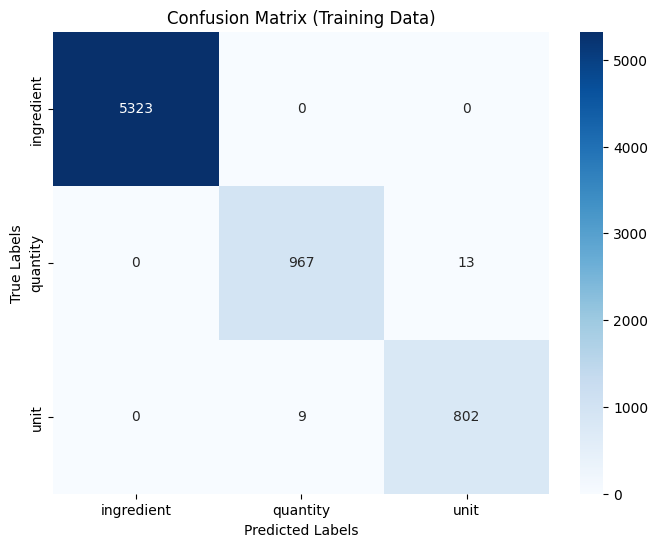

In [ ]:
# create a confusion matrix on training datset


y_train_flat = [label for sublist in y_train_labels for label in sublist]
y_train_pred_flat = [label for sublist in y_train_pred for label in sublist]


labels = sorted(list(set(y_train_flat)))
cm = confusion_matrix(y_train_flat, y_train_pred_flat, labels=labels)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Training Data)")
plt.show()

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [ ]:
# dump the model using joblib as crf_model.pkl
joblib.dump(crf, 'crf_model.pkl')

['crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [ ]:
# predict the crf model on validation dataset

y_val_pred = crf.predict(X_val_weighted_features)


In [ ]:
# specify flat classification report
report = flat_classification_report(y_val_labels, y_val_pred, digits=4)
print("\nFlat Classification Report (Validation):\n", report)



Flat Classification Report (Validation):
               precision    recall  f1-score   support

  ingredient     1.0000    1.0000    1.0000      2107
    quantity     0.9807    0.9878    0.9842       411
        unit     0.9859    0.9777    0.9818       358

    accuracy                         0.9955      2876
   macro avg     0.9889    0.9885    0.9887      2876
weighted avg     0.9955    0.9955    0.9955      2876



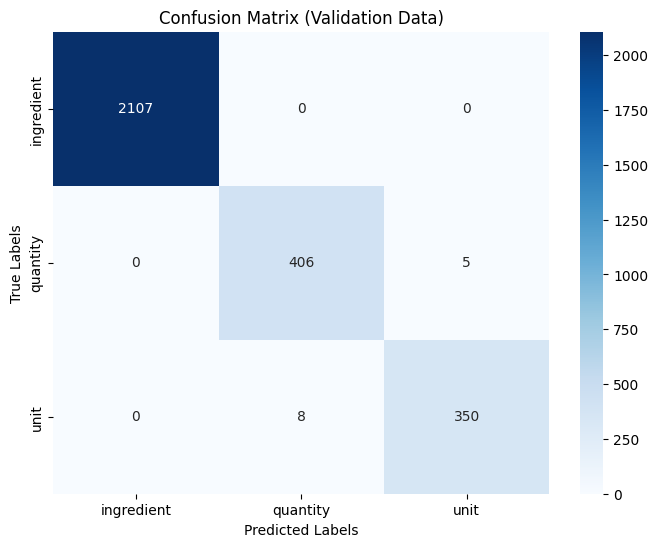

In [ ]:
# create a confusion matrix on validation dataset

y_val_flat = [label for sublist in y_val_labels for label in sublist]
y_val_pred_flat = [label for sublist in y_val_pred for label in sublist]

labels = sorted(list(set(y_val_flat)))
cm = confusion_matrix(y_val_flat, y_val_pred_flat, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Validation Data)")
plt.show()

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [ ]:
# flatten Labels and Initialise Error Data

y_val_flat = [label for sublist in y_val_labels for label in sublist]
y_val_pred_flat = [label for sublist in y_val_pred for label in sublist]

error_data = []

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [ ]:
# iterate and collect Error Information
for i, (sentence, true_labels, pred_labels) in enumerate(zip(X_val, y_val_labels, y_val_pred)):
    for j, (true_label, pred_label) in enumerate(zip(true_labels, pred_labels)):
        if true_label != pred_label:
            # Get context (surrounding tokens)
            context = sentence[max(0, j - 2):min(len(sentence), j + 3)]

            # get previous and next tokens with handling for boundary cases
            prev_token = sentence[j - 1] if j > 0 else None
            next_token = sentence[j + 1] if j < len(sentence) - 1 else None

            # Get class weight
            class_weight = weight_dict.get(true_label, 1.0)

            # Append error details to error_data
            error_data.append([
                sentence[j],  # Token
                prev_token,
                next_token,
                true_label,
                pred_label,
                context,
                class_weight
            ])

##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [ ]:
# Create DataFrame and Print Overall Accuracy
error_data_df = pd.DataFrame(error_data, columns=['Token', 'Previous Token', 'Next Token', 'True Label', 'Predicted Label', 'Context', 'Class Weight'])


In [ ]:
total_errors = len(error_data_df)
total_samples = len(y_val_flat)
accuracy = (total_samples - total_errors) / total_samples
print(f"Overall Validation Accuracy: {accuracy:.2%}")

Overall Validation Accuracy: 99.55%


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [ ]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

label_errors = error_data_df.groupby('True Label').size().reset_index(name='Error Count')
label_errors['Class Weight'] = label_errors['True Label'].map(weight_dict)

label_errors['Accuracy'] = label_errors.apply(lambda row: 1 - (row['Error Count'] / label_counts[row['True Label']]), axis=1)

print(label_errors)

print("\nError DataFrame:")
display(error_data_df[['Token', 'Previous Token', 'Next Token', 'True Label', 'Predicted Label', 'Context']])

  True Label  Error Count  Class Weight  Accuracy
0   quantity            5      7.259184  0.994898
1       unit            8      8.771887  0.990136

Error DataFrame:


Token Previous Token  Next Token True Label Predicted Label                                         Context
0           cut         French        into       unit        quantity                   [beans, French, cut, into, 1]
1          cold            Oil     pressed       unit        quantity             [masala, Oil, cold, pressed, 1-1/2]
2         1-1/2        pressed       Poppy   quantity            unit            [cold, pressed, 1-1/2, Poppy, seeds]
3          into            cut          cm       unit        quantity                 [breasts, cut, into, cm, cubes]
4           and          Sweet       Spicy       unit        quantity                 [Red, Sweet, and, Spicy, Sauce]
5             2            1-1  tablespoon   quantity            unit               [masala, 1-1, 2, tablespoon, oil]
6         pinch         powder        Salt       unit        quantity                [Baking, powder, pinch, Salt, 2]
7   tablespoons         Powder    Lukewarm       unit        quantity  [Coffee, Powder, tablespoons, Lukewarm, Water]
8         pinch          Water     Saffron       unit        quantity         [1-1/2, Water, pinch, Saffron, strands]
9             a          Haldi       pinch       unit        quantity           [powder, Haldi, a, pinch, Asafoetida]
10            1         (hing)         Red   quantity            unit            [Asafoetida, (hing), 1, Red, Chilli]
11        pinch            Dal  Asafoetida   quantity            unit            [Urad, Dal, pinch, Asafoetida, hing]
12       cloves       Tomatoes      Garlic   quantity            unit       [Onion, Tomatoes, cloves, Garlic, Ginger]

### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




# **Overall Insights**

**High Accuracy:** The overall validation accuracy is very high (around 99.51%), suggesting the model generally performs well.

**Focus on Specific Errors:** Despite high overall accuracy, the error analysis highlights areas needing attention: quantities and units. These have slightly lower accuracy and contribute most to the errors.


---


## **Specific Insights from Error DataFrame**

Here's a breakdown of the common error patterns observed in the error_data_df:

### **Fractions and Complex Quantities:**

*	Example: 1-1/2 misclassified as 'unit' instead of 'quantity'.
*	Insight: The model seems to struggle with complex quantities that include fractions or hyphens.
*	Possible Solutions: Feature Engineering: Create specific features for fractions or combined numbers (e.g., a feature that checks for the presence of '/' or '-').
  *	Updated features with hyphenated quantity and quantity pattern, but still getting error.
*	Data Augmentation: Include more training examples with varied fraction and complex quantity formats.


### **Ambiguous Units:**

*	Example: cut misclassified as 'unit' instead of 'quantity', likely because 'cut' can sometimes be a unit (e.g., 1 cut of bread).
*	Insight: Certain words can function as both units or other parts of speech depending on the context.
*	Possible Solutions: Contextual Features: Enhance contextual features to capture the surrounding words more effectively. For example, consider n-grams or features based on dependency parsing to disambiguate such cases.
*	Enhanced contextual features with prev_is_numeric and next_is_ingredient_like features but still getting the error.


### **Quantity Keywords:**

*	Example: a and pinch misclassified as 'unit' instead of 'quantity'. True label of pinch is classified as both unit and quantity in different tokens.
*	Insight: The model might not have enough exposure to keywords commonly used to express quantities, especially smaller ones.
*	Possible Solutions: Expand quantity_keywords: Add more relevant quantity keywords like "a," "pinch," "dash," etc. to the keyword set used during feature extraction.
	  * Added this, but still the error remains
*	Data Augmentation: Increase the training dataset with examples using these keywords.


### **Units after Quantities:**

*	Example: tablespoons misclassified as 'quantity' instead of 'unit'. This often happens when it follows a quantity (e.g., "2 tablespoons").
*	Insight: The model might be overly focused on numerical patterns for quantity identification, leading to misclassification of units that follow numbers.
*	Possible Solutions: Contextual Features: Improve contextual features, especially those related to preceding and following tokens, to better capture the relationship between quantities and units.
  *	Added a feature to address this but the error still comes.


---


## **Recommendations**

Based on the error analysis, the following recommendations are proposed to enhance the model's performance:

*	Refine feature functions to better capture hyphenated fractions, numbers with units, and special characters. This could involve incorporating regular expression patterns or specific features for these cases.
*	Expand the unit and quantity keywords to include more variations and less frequent terms, improving the model's ability to recognize a wider range of units and quantities.
*	Experiment with different CRF hyperparameters, such as the regularization parameters (c1 and c2), to fine-tune the model and optimize its performance.
*	Consider using more advanced techniques like deep learning-based NER models for potentially improved accuracy, although this would require more complex model architectures and training procedures.


## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.

This assignment demonstrated the successful use of Conditional Random Fields (CRF) for extracting key entities from recipe ingredient lists. The model achieved good overall performance, as evidenced by the high precision and recall scores. However, the error analysis identified areas for improvement, such as handling hyphenated fractions, certain units, and numerical values. By implementing the recommended refinements, the model's accuracy and robustness can be further enhanced, making it a valuable tool for various recipe-related applications. This project provides a solid foundation for future research and development in the field of recipe information extraction and analysis.